# FDCHP Data Processing

This Notebook demonstrates how to process FDCHP data using the tools in the `ooi-data-explorations.python.examples.fdchp` library.

This requires setting up a python environment that contains the necessary dependencies to use in this notebook.

Alongside the base repository containing this Notebook (the location of the `ooi-data-explorations` repository, clone the `mi-instrument` repo 

```
git clone https://github.com/joffreyp/mi-instrument.git
```

Create a new python virtual environment:

```
cd ~
mkdir venv
python -m venv ~/venv
source venv/bin/activate
```

Install mi-instrument requirements:

```
pip install -r mi-instrument/requirements_py3.txt
```

Install `ooi-data-explorations` and `mi-instruments`: 

```
pip install -e ooi-data-explorations/python/
pip install -e mi-instrument/
```

Prepare environment for use by Jupyter Notebook kernel:

```
pip install ipykernel
pip install ipympl
python -m ipykernel install --user --name=fdchp
vi ~/.local/share/jupyter/kernels/fdchp/kernel.json
```

And replace the first line of the `argv` array in `kernel.json` with the python from the new .venv: `"~/.venv/bin/python",`

Now, select the `Kernel` menu, click `Change kernel...` and select the new `fdchp` environment.


## Import necessary libraries

In [1]:
import os
from glob import glob
import re
import ntplib

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from examples.fdchp import fdchp_utils
from examples.fdchp.fdchp_utils import particles_to_pandas, read_file, read_file_to_pandas
from examples.fdchp.process_fdchp import process_fdchp
from examples.fdchp.plot_fdchp import plot_x_velocity_vs_wind_speed, plot_wave_height_vs_wind_speed


/home/jovyan/mi-instrument/mi/core/log.py:108: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  parsed = yaml.load(logconfig)
/home/jovyan/ooi-data-explorations/python/examples/fdchp/plot_fdchp.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma_H$ (m)')


## Select and load dataset from raw data server

In [2]:
files_deployment1 = glob(os.path.join("/home/jovyan/ooi/uncabled/GI01SUMO/R00001/instruments/dcl12/FDCHP_sn*/", "*/*.dat"))
files_deployment2 = glob(os.path.join("/home/jovyan/ooi/uncabled/GI01SUMO/R00002/instruments/dcl12/FDCHP_sn*/", "*/*.dat"))
files_deployment3 = glob(os.path.join("/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn*/", "*/*.dat"))
files_deployment4 = glob(os.path.join("/home/jovyan/ooi/uncabled/GI01SUMO/R00004/instruments/dcl12/FDCHP_sn*/", "*/*.dat"))
files_deployment5 = glob(os.path.join("/home/jovyan/ooi/uncabled/GI01SUMO/R00005/instruments/dcl12/FDCHP_sn*/", "*/*.dat"))
files_deployment6 = glob(os.path.join("/home/jovyan/ooi/uncabled/GI01SUMO/R00006/instruments/dcl12/FDCHP_sn*/", "*/*.dat"))
files_deployment7 = glob(os.path.join("/home/jovyan/ooi/uncabled/GI01SUMO/R00007/instruments/dcl12/FDCHP_sn143401/", "*/*.dat"))
files_deployment8 = glob(os.path.join("/home/jovyan/ooi/uncabled/GI01SUMO/R00008/instruments/dcl12/FDCHP_sn*/", "*/*.dat"))
files_deployment9 = glob(os.path.join("/home/jovyan/ooi/uncabled/GI01SUMO/R00009/instruments/dcl12/FDCHP_sn*/", "*/*.dat"))

In [5]:
files_deployment3.sort()

In [6]:
files_deployment3

['/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn133908/D201606/fdchp_20160622_100000.dat',
 '/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn133908/D201606/fdchp_20160622_110000.dat',
 '/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn133908/D201606/fdchp_20160622_120000.dat',
 '/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn133908/D201606/fdchp_20160622_125400.dat',
 '/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn133908/D201606/fdchp_20160622_132000.dat',
 '/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn133908/D201606/fdchp_20160622_160100.dat',
 '/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn133908/D201606/fdchp_20160622_170100.dat',
 '/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn133908/D201606/fdchp_20160622_180300.dat',
 '/home/jovyan/ooi/uncabled/GI01SUMO/R00003/instruments/dcl12/FDCHP_sn133908/D201606/fdchp_20160

In [3]:
print(len(files_deployment1))
print(len(files_deployment2))
print(len(files_deployment3))
print(len(files_deployment4))
print(len(files_deployment5))
print(len(files_deployment6))
print(len(files_deployment7))
print(len(files_deployment8))
print(len(files_deployment9))


0
0
6026
0
0
6994
10604
3514
8253


In [4]:
def process_raw_files(file_list, output_filepath='fluxes'):
    # Set up some variables for FDCHP processing
    instrument_dir = file_list[0].split('uncabled')[-1]
    if instrument_dir.startswith('PA'):
        lat=40.1334        #Pioneer NES
        instrument_rel_position=[-0.75, 0, -5]
    elif instrument_dir.startswith('IS'):
        lat=59.9337        #Irminger Sea
        instrument_rel_position=[-0.75, 0, -6] 
    else:
        lat=44.6393        #Endurance
        instrument_rel_position=[-0.5, -0.5, -5]
    
    output_filename = "fluxes{}"
    errors = {}
    U=[]
    uw=[]
    sigH=[]
    times=[]
    data = []
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)
    print("Processing {} files.".format(len(file_list)))
    incr=0
    print("Start time: {}".format(datetime.now()))
    data_readin_accumulator = timedelta(0)
    data_processed_accumulator = timedelta(0)
    # for incr in np.arange(24):
    for filename in file_list:
        #****************************************
        # Read in raw data
        #**********************************
    
        start = datetime.now()
        file_basename = os.path.basename(filename)
        try:
            raw_data = read_file_to_pandas(filename)
            if raw_data is None:
                incr += 1
                errors[filename] = "Empty file: {}".format(filename)
                continue
        except Exception as e:
            print("Exception processing file {}: {}".format(filename, e))
            errors[filename] = e
    
        data_readin = datetime.now()
        data_readin_accumulator = data_readin_accumulator + (data_readin-start)
        #*****************************************
        # Compute flux data
        #*****************************************   
        try:
            fluxes, Uearth, waveheight = process_fdchp(raw_data, lat, instrument_rel_position, flux_filepath=os.path.join(output_filepath, output_filename.format(file_basename.split('.dat')[0])))
        except Exception as e:
            # Error processing data; probably too few datapoints
            print("Error processing fdchp dataset: {}".format(e))
            incr +=1
            errors[filename] = e
            continue
        processed = datetime.now()
        data_processed_accumulator = data_processed_accumulator + (processed-data_readin)
        if incr %100 == 0:
            print("File processing finished for file {}: {}. Read-in time: {}, Process time: {}".format(incr, file_basename, data_readin_accumulator, data_processed_accumulator))
            data_readin_accumulator = timedelta(0)
            data_processed_accumulator = timedelta(0)
        uw = uw + [fluxes[0]]        # Fluxes: uw vw wT
        U = U + [Uearth]              # Wind speed relative to earth  
        sigH = sigH + [waveheight]    # Significant wave height
        times = times + [raw_data['time'].mean()]
        incr += 1
    
    uw = np.array(uw)
    U = np.array(U)
    sigH = np.array(sigH)
    times = np.array(times)
    
    print("{} errors during processing.".format(len(errors)))
    print("End time: {}".format(datetime.now()))

    return uw, U, sigH, times, errors

## Deployments 1, 2, 4, 5 all have missing recovered data

## Process all the files for deployment 3

## Process all the files for deployment 8

Processing 3514 files.
Start time: 2024-11-22 19:07:37.203305
File processing finished for file 0: fdchp_20210918_230200.dat. Read-in time: 0:00:00.504776, Process time: 0:00:00.067002
File processing finished for file 100: fdchp_20210925_050200.dat. Read-in time: 0:00:54.501171, Process time: 0:00:06.883275
File processing finished for file 200: fdchp_20210920_110200.dat. Read-in time: 0:00:54.634995, Process time: 0:00:06.903074
File processing finished for file 300: fdchp_20210930_220200.dat. Read-in time: 0:00:54.514516, Process time: 0:00:06.874108
File processing finished for file 400: fdchp_20210920_000200.dat. Read-in time: 0:00:54.425007, Process time: 0:00:06.865234
File processing finished for file 500: fdchp_20210913_210200.dat. Read-in time: 0:00:54.443696, Process time: 0:00:06.839658
File processing finished for file 600: fdchp_20210904_000200.dat. Read-in time: 0:00:54.501650, Process time: 0:00:06.875954
File processing finished for file 700: fdchp_20210903_020200.dat.

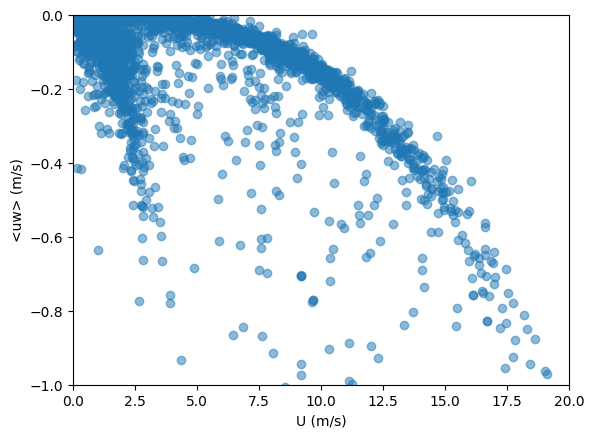

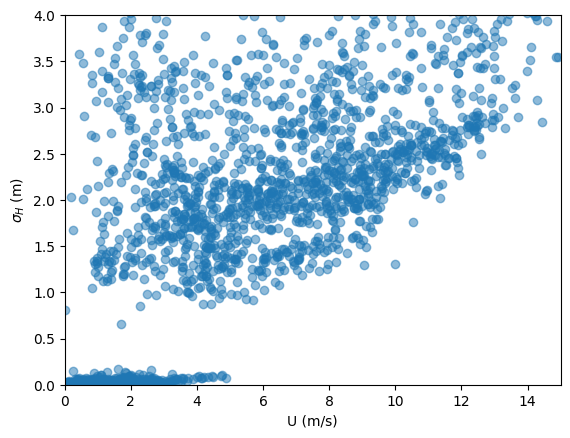

In [8]:
# uw_deployment8, U_deployment8, sigH_deployment8, times_deployment8, errors_deployment8 =  process_raw_files(files_deployment8, "deployment8/fluxes")
# plot_x_velocity_vs_wind_speed(U_deployment8, uw_deployment8)
# plot_wave_height_vs_wind_speed(U_deployment8, sigH_deployment8)

## Get Telemetered data from kdata directory

In [11]:
from ooi_data_explorations.common import load_kdata
# telemetered1 = load_kdata('GI01SUMO', 'SBD12', '08-FDCHPA000', 'telemetered', 'fdchp_a_dcl_instrument', 'deployment0001*.nc')
# telemetered2 = load_kdata('GI01SUMO', 'SBD12', '08-FDCHPA000', 'telemetered', 'fdchp_a_dcl_instrument', 'deployment0002*.nc')
# telemetered3 = load_kdata('GI01SUMO', 'SBD12', '08-FDCHPA000', 'telemetered', 'fdchp_a_dcl_instrument', 'deployment0003*.nc')
# telemetered4 = load_kdata('GI01SUMO', 'SBD12', '08-FDCHPA000', 'telemetered', 'fdchp_a_dcl_instrument', 'deployment0004*.nc')
# telemetered5 = load_kdata('GI01SUMO', 'SBD12', '08-FDCHPA000', 'telemetered', 'fdchp_a_dcl_instrument', 'deployment0005*.nc')
# telemetered6 = load_kdata('GI01SUMO', 'SBD12', '08-FDCHPA000', 'telemetered', 'fdchp_a_dcl_instrument', 'deployment0006*.nc')
# telemetered7 = load_kdata('GI01SUMO', 'SBD12', '08-FDCHPA000', 'telemetered', 'fdchp_a_dcl_instrument', 'deployment0007*.nc')
telemetered8 = load_kdata('GI01SUMO', 'SBD12', '08-FDCHPA000', 'telemetered', 'fdchp_a_dcl_instrument', 'deployment0008*.nc')
# telemetered9 = load_kdata('GI01SUMO', 'SBD12', '08-FDCHPA000', 'telemetered', 'fdchp_a_dcl_instrument', 'deployment0009*.nc')


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

Merging the data files into a single dataset


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Merging the data files into a single dataset


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Merging the data files into a single dataset


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Merging the data files into a single dataset


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


Merging the data files into a single dataset


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Merging the data files into a single dataset


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Merging the data files into a single dataset


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Merging the data files into a single dataset
Loading and Processing Data Files: 100%|██████████| 217/217 [00:02<00:00, 78.47it/s]
Merging the data files into a single dataset


## Output data in csv format

In [12]:
# df_deployment3_calculated = pd.DataFrame({"time":times_deployment3, 'uw_momentum_flux': uw_deployment3})
# df_deployment3_calculated = df_deployment3_calculated.sort_values('time', ascending=True)
# df_deployment3_calculated.to_csv("calculated_deployment3.csv")
# df_deployment6_calculated = pd.DataFrame({"time":times_deployment6, 'uw_momentum_flux': uw_deployment6})
# # df_deployment6_calculated = df_deployment6_calculated.sort_values('time', ascending=True)
# df_deployment6_calculated.to_csv("calculated_deployment6.csv")
# df_deployment7_calculated = pd.DataFrame({"time":times_deployment7, 'uw_momentum_flux': uw_deployment7})
# # df_deployment7_calculated = df_deployment7_calculated.sort_values('time', ascending=True)
# df_deployment7_calculated.to_csv("calculated_deployment7.csv")
# df_deployment8_calculated = pd.DataFrame({"time":times_deployment8, 'uw_momentum_flux': uw_deployment8})
# # df_deployment8_calculated = df_deployment8_calculated.sort_values('time', ascending=True)
# df_deployment8_calculated.to_csv("calculated_deployment8.csv")
# df_deployment9_calculated = pd.DataFrame({"time":times_deployment9, 'uw_momentum_flux': uw_deployment9})
# # df_deployment9_calculated = df_deployment9_calculated.sort_values('time', ascending=True)
# df_deployment9_calculated.to_csv("calculated_deployment9.csv")

In [13]:
# df_deployment1_telemetered = telemetered1[['time','uw_momentum_flux']].to_dataframe()
# df_deployment1_telemetered.to_csv("telemetered_deployment1.csv")
# df_deployment2_telemetered = telemetered2[['time','uw_momentum_flux']].to_dataframe()
# df_deployment2_telemetered.to_csv("telemetered_deployment2.csv")
# df_deployment3_telemetered = telemetered3[['time','uw_momentum_flux']].to_dataframe()
# df_deployment3_telemetered.to_csv("telemetered_deployment3.csv")
# df_deployment4_telemetered = telemetered4[['time','uw_momentum_flux']].to_dataframe()
# df_deployment4_telemetered.to_csv("telemetered_deployment4.csv")
# df_deployment5_telemetered = telemetered5[['time','uw_momentum_flux']].to_dataframe()
# df_deployment5_telemetered.to_csv("telemetered_deployment5.csv")
# df_deployment6_telemetered = telemetered6[['time','uw_momentum_flux']].to_dataframe()
# df_deployment6_telemetered.to_csv("telemetered_deployment6.csv")
# df_deployment7_telemetered = telemetered7[['time','uw_momentum_flux']].to_dataframe()
# df_deployment7_telemetered.to_csv("telemetered_deployment7.csv")
# df_deployment8_telemetered = telemetered8[['time','uw_momentum_flux']].to_dataframe()
# df_deployment8_telemetered.to_csv("telemetered_deployment8.csv")
# df_deployment9_telemetered = telemetered9[['time','uw_momentum_flux']].to_dataframe()
# df_deployment9_telemetered.to_csv("telemetered_deployment9.csv")

## Plot calculated vs telemetered

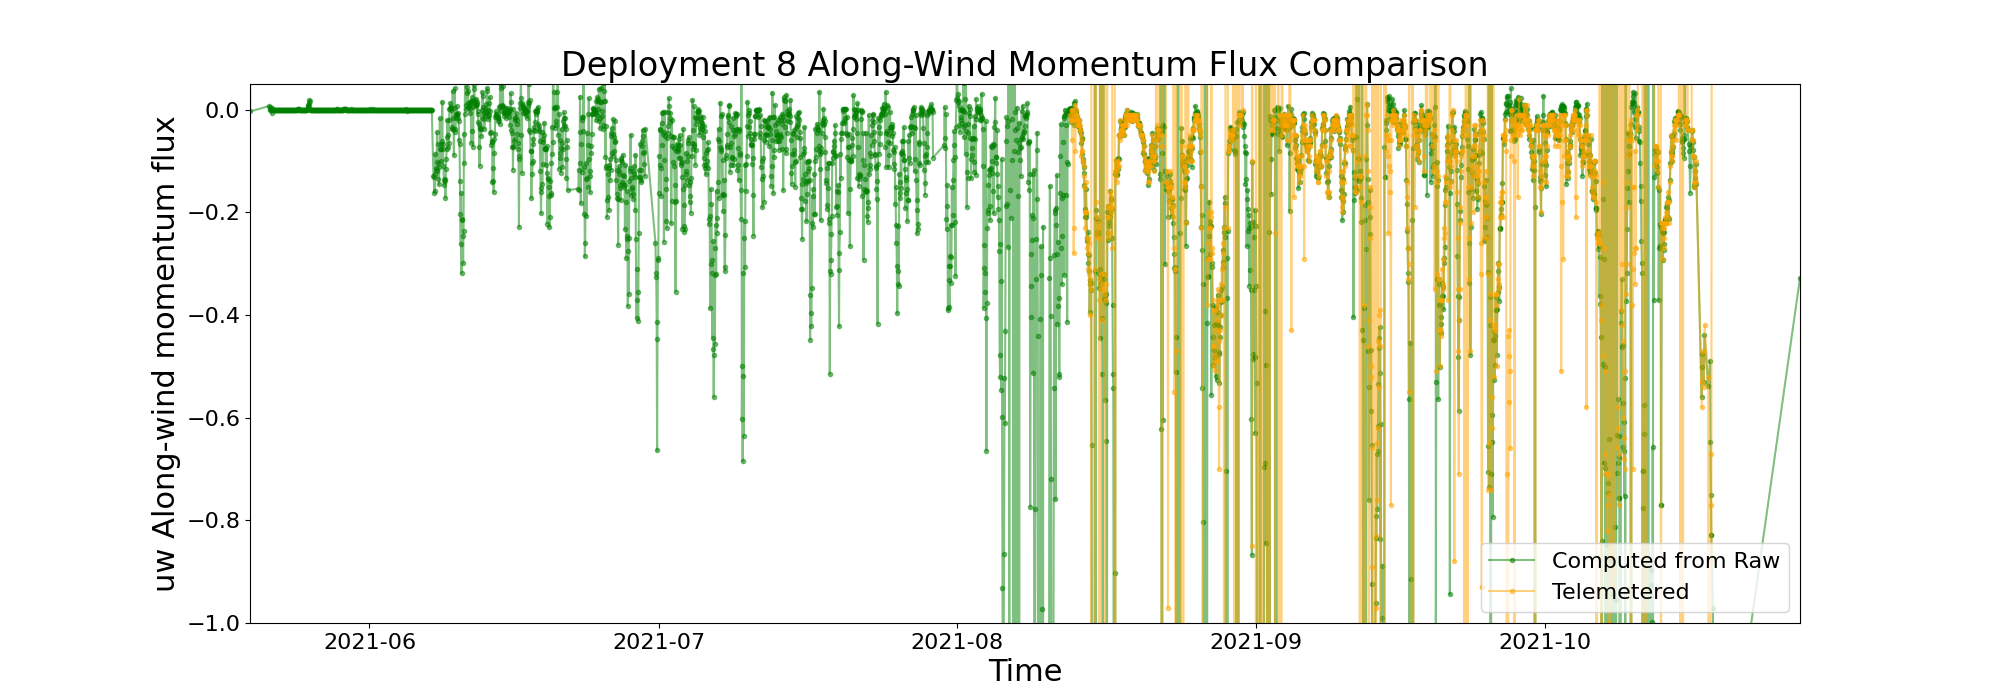

In [17]:
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
# %matplotlib inline
%matplotlib ipympl

# time_2021_recovered = (ntplib.ntp_to_system_time(ds2021_recovered['fdchp_a_time_L2'].values)).astype('datetime64[s]')
marker_size = 3
legend_marker_size = 20
tick_size = 16

def update(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([legend_marker_size])
    
fig, ax = plt.subplots(figsize=(20, 7))
df_deployment8_calculated = df_deployment8_calculated.sort_values('time', ascending=True)
ax.plot(df_deployment8_calculated['time'], df_deployment8_calculated['uw_momentum_flux'], marker='o',linestyle='solid',markersize=marker_size, color='green', alpha=0.5, label="Computed from Raw")

scatter = ax.plot(telemetered8['time'], telemetered8['uw_momentum_flux'], marker='o',linestyle='solid', color='orange', markersize=marker_size, alpha=0.5, label="Telemetered")
# scatter = ax.scatter(time_2021_recovered, ds2021_recovered['fdchp_a_fluxmom_alongwind'], marker='x', color='purple', s=marker_size, alpha=0.5, label="Recovered")
ax.set_xlabel('Time', fontsize=22)
# ax.set_xlim(np.min(telemetered8['time']), np.max(telemetered8['time']))
ax.set_xlim(np.min(df_deployment8_calculated['time']), np.max(df_deployment8_calculated['time']))
ax.set_ylabel('uw Along-wind momentum flux', fontsize=22)
ax.set_ylim(-1.0, 0.05)
# handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend = ax.legend(loc="lower right", fontsize=tick_size, handler_map={PathCollection : HandlerPathCollection(update_func=update)})
legend = ax.legend(loc="lower right", fontsize=tick_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title("Deployment 8 Along-Wind Momentum Flux Comparison", fontsize=24)
plt.savefig('deployment8_comparison.png', bbox_inches='tight')
plt.show()

In [20]:
plt.close()